In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler



In [6]:
train = pd.read_csv('/Users/rfalcao/Documents/MNIST/MNIST_comp/train 2.csv')


In [7]:
y_train = train["label"]  # Copy labels
y_train= to_categorical(y_train, num_classes = 10) # One-hot encode the labels
train = train.drop(columns=["label"]) / 255  # Normalize without modifying the original
train_xCNN=train.to_numpy().reshape(-1, 28, 28, 1)

In [8]:
# model_CNN = keras.Sequential([
#     keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
#     keras.layers.MaxPooling2D((2,2)),
#     keras.layers.Conv2D(64, (3,3), activation='relu'),
#     keras.layers.MaxPooling2D((2,2)),
#     keras.layers.Flatten(),
#     keras.layers.Dense(128, activation='relu'),
#     keras.layers.Dense(10, activation='softmax')  # 10 output classes
# ])
model_CNN = keras.Sequential([
    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2,2)),
    
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, (3,3), strides=2, padding='same', activation='relu'),  # Strided convolution instead of pooling
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.4),  # Regularization
    
    keras.layers.Flatten(),
    keras.layers.Dense(128),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.Dropout(0.4),  # Regularization
    keras.layers.Dense(10, activation='softmax')  # 10 output classes
])

model_CNN.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Summary
model_CNN.summary()

/Users/rfalcao/anaconda3/envs/tf-m2/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 11, 11, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 6, 6, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 6, 6, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 353,226 (1.35 MB)

 Trainable params: 352,650 (1.35 MB)

 Non-trainable params: 576 (2.25 KB)

In [9]:
datagen = ImageDataGenerator(
        rotation_range=30,  
        zoom_range = 0.15,  
        width_shift_range=0.15, 
        height_shift_range=0.15)

In [13]:
epochs = 10
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.98 ** x)

# Train-test split
X_train2, X_val2, Y_train2, Y_val2 = train_test_split(train_xCNN, y_train, test_size=0.1)  # FIXED

# Train model
history = model_CNN.fit(datagen.flow(X_train2, Y_train2, batch_size=64),  # FIXED
                        epochs=epochs,
                        steps_per_epoch=len(X_train2) // 64,
                        validation_data=(X_val2, Y_val2),
                        callbacks=[annealer],
                        verbose=1)

# Evaluate model
val_loss, val_acc = model_CNN.evaluate(X_val2, Y_val2)
print(f"Validation Accuracy: {val_acc:.4f}")

Epoch 1/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 29s 49ms/step - accuracy: 0.9741 - loss: 0.0870 - val_accuracy: 0.9890 - val_loss: 0.0361 - learning_rate: 0.0010
Epoch 2/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 0.0137 - val_accuracy: 0.9895 - val_loss: 0.0372 - learning_rate: 9.8000e-04
Epoch 3/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 30s 52ms/step - accuracy: 0.9725 - loss: 0.0879 - val_accuracy: 0.9843 - val_loss: 0.0472 - learning_rate: 9.6040e-04
Epoch 4/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9688 - loss: 0.1045 - val_accuracy: 0.9850 - val_loss: 0.0451 - learning_rate: 9.4119e-04
Epoch 5/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 30s 51ms/step - accuracy: 0.9746 - loss: 0.0862 - val_accuracy: 0.9933 - val_loss: 0.0239 - learning_rate: 9.2237e-04
Epoch 6/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9688 - loss: 0.1597 - val_accuracy: 0.9933 - val_loss: 0.0236 - learning_rate: 9.0392e-04
Epoch 7/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 28s 47ms/step - accura

In [14]:
model_CNN.save('trained_model2.h5')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━

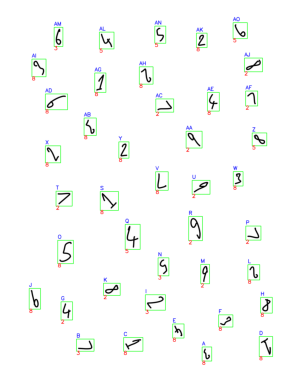

Predicted Digit: 8 at label A with position (1116, 1967, 56, 82)
Predicted Digit: 3 at label B with position (386, 1921, 102, 71)
Predicted Digit: 8 at label C with position (660, 1912, 112, 80)
Predicted Digit: 8 at label D with position (1448, 1906, 78, 117)
Predicted Digit: 8 at label E with position (945, 1833, 66, 82)
Predicted Digit: 8 at label F with position (1212, 1780, 83, 71)
Predicted Digit: 2 at label G with position (296, 1704, 67, 106)
Predicted Digit: 8 at label H with position (1456, 1678, 68, 92)
Predicted Digit: 3 at label I with position (786, 1663, 117, 90)
Predicted Digit: 8 at label J with position (111, 1626, 66, 121)
Predicted Digit: 2 at label K with position (543, 1596, 97, 71)
Predicted Digit: 8 at label L with position (1382, 1488, 69, 89)
Predicted Digit: 2 at label M with position (1108, 1486, 51, 113)
Predicted Digit: 3 at label N with position (860, 1448, 63, 105)
Predicted Digit: 8 at label O with position (277, 1346, 91, 136)
Predicted Digit: 2 at lab

In [16]:


from Digit_Segmenter import DigitSegmenter

# Initialize with the trained model path
segmenter = DigitSegmenter('trained_model.h5')

# Path to the image you want to process
image_path = '/Users/rfalcao/FYP/Digit_identifier/TestSeq1.jpg'

padding=10
# Segment digits
segmented_image, predicted_digits = segmenter.segment_digits_with_labels(image_path,padding)

# Display result
segmenter.display_image(segmented_image)

# Print predicted digits with their Excel-like labels
for digit, label, position in predicted_digits:
    print(f"Predicted Digit: {digit} at label {label} with position {position}")

Not working to full acceptability